In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from ase import Atoms

from y2ace_funcs import *

# Dataset characteristics

## Pair distance distribution

In [2]:
os.chdir("/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace/")
# es01_dataset = load_gzip('datasets/es01.pckl.gzip')
tr1k_dataset = load_gzip('datasets/Carbon_full/Tr1k_n.pckl.gzip')
dia1k_dataset = load_gzip('datasets/Tr1k_dia.pckl.gzip')

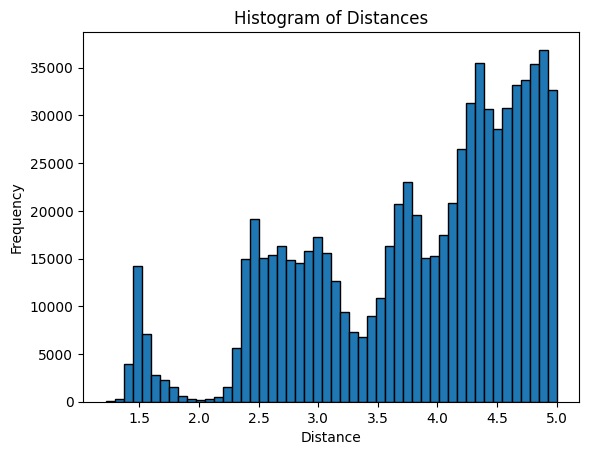

In [3]:
dists = np.array([])
for atoms in dia1k_dataset['ase_atoms']:
    dists = np.append(dists, strucs2dists(atoms,rcut=5,warn=False))

distcount, edges = np.histogram(dists, bins=50)
plt.bar(edges[:-1], distcount / 2, width=np.diff(edges), align='edge', edgecolor='black')
# plt.bar(edges[:-1], distcount, width=np.diff(edges), align='edge', edgecolor='black', alpha=0.5)
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Distances')
plt.show()

# Loss and dimer curves

## Dimers 

In [2]:
pwd()

'/leonardo_work/Sis25_degironc_0/apol/aceconverge2025'

In [3]:
# acepotentials.jl files
os.chdir("/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/")
acejl_Tr124_dim_kappa1 = np.loadtxt('Tr124_dim/border3/dimercurve.dat').T
acejl_Tr124_dim_kappa50 = np.loadtxt('Tr124_dim/border4/dimercurve.dat').T

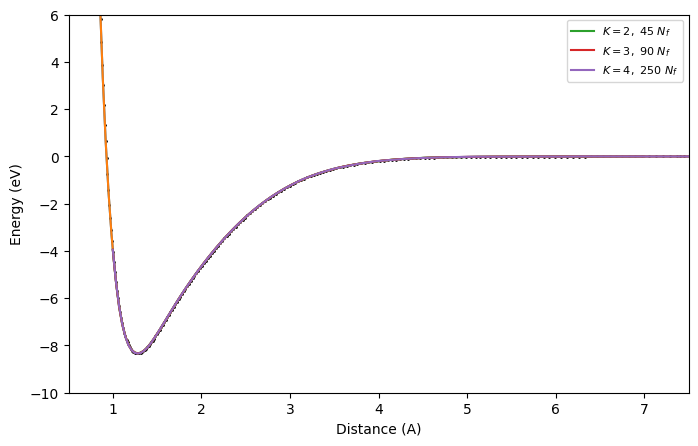

In [5]:
# pacemaker-related files
os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(1,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

potdirs = ['datafiles/Tr124_dim/border/b_order'+str(i)+'/' for i in range(2,5)]
datasets = [r'$K=2,$ $45$ $N_f$', r'$K=3,$ $90$ $N_f$', r'$K=4,$ $250$ $N_f$']

g,gax = plt.subplots(1,1,figsize=(8,4.5))
# g.suptitle(plot_title)
g.subplots_adjust(top=0.95)
# gax.scatter(*en_qe,s=1,color='k',label='DFT')

# DFT data
gax.scatter(*en_qe,s=1,color='k')

# ACE-JL
for acejl in [acejl_Tr124_dim_kappa1, acejl_Tr124_dim_kappa50]:
    gax.plot(*acejl)

# pacemaker
for i,dir in enumerate(potdirs):
    gax.plot(r, en_ase(r, dir, 'output_potential.yaml'), label=datasets[i])
gax.set_xlabel('Distance (A)')
gax.set_ylabel('Energy (eV)')
# gax.set_xlim(1.1391207805825228,7.5)
gax.set_xlim(0.5,7.5)
gax.set_ylim(-10,6)
gax.legend(fontsize=8)
# g.savefig('figures/curvestab_dim124_abstract.png',bbox_inches='tight')

## Diamonds

## Diverse

### `ace.jl` analysis

In [3]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(1,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

#### Tr1k_dia (`ACEpotentials.jl`)

FileNotFoundError: Tr1k_dia_purify/24.20/ecost10.0/dimercurve.dat not found.

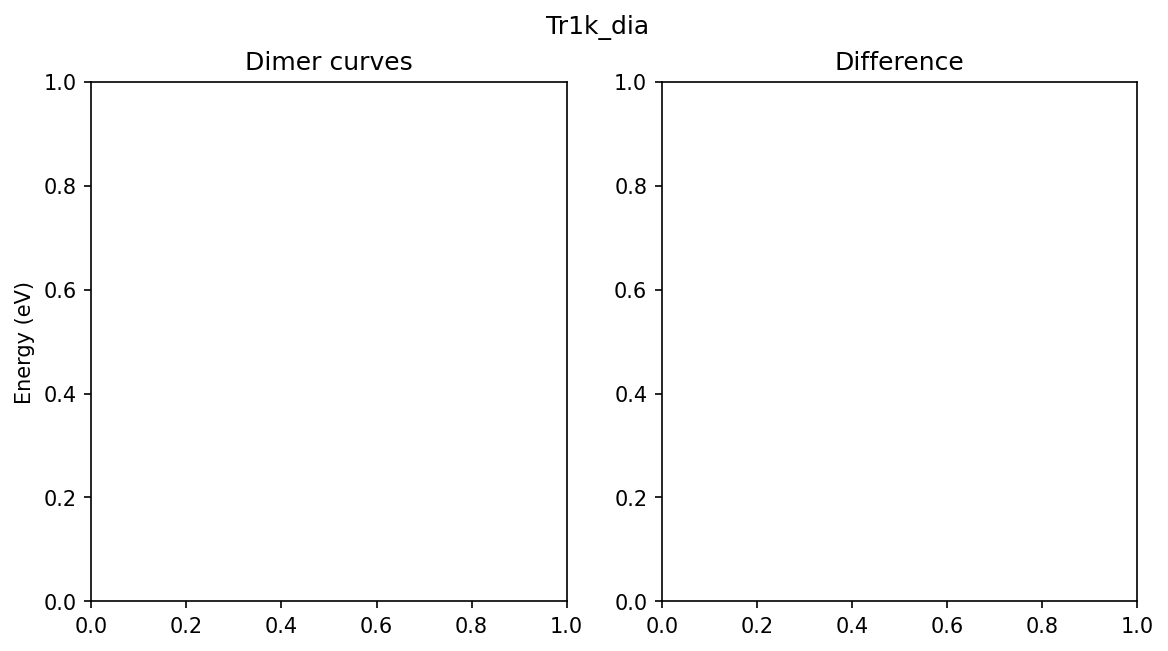

In [4]:
## Progressive convergence wrt dimgen 

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
basis_tags = ['24.20','24.20.16']
# dset = 'dimgen_247'
# dimgens = ['50','100','150','200','247']
dset = 'Tr1k_dia'
jl_dims = {}
jl_puredims = {}
# basis_set = '24.20.16.12'

g, gax = plt.subplots(1,2,figsize=(9,4.5),dpi=150)
g.suptitle(f'{dset}')
# g.subplots_adjust(top=0.95)
g.subplots_adjust(wspace=0.2)
gax[0].set_title('Dimer curves')
gax[1].set_title('Difference')
gax[0].set_ylabel('Energy (eV)')
for i,basis in enumerate(basis_tags):
    # jl_dims[basis] = np.loadtxt(f'{dset}'+'/'+basis+'/ecost10.0/dimercurve.dat').T
    jl_puredims[basis] = np.loadtxt(f'{dset}'+'_purify/'+basis+'/ecost10.0/dimercurve.dat').T  
    # diffy = jl_dims[basis][1] - jl_puredims[basis][1]  
    if i == 0:
        # gax[0].plot(*jl_dims[basis], label="self-interacting", color="C"+str(i), linestyle='--')
        gax[0].plot(*jl_puredims[basis], label="canonical", color="C"+str(i), alpha=0.5)
    else:
        # gax[0].plot(*jl_dims[basis], color="C"+str(i), linestyle='--')
        gax[0].plot(*jl_puredims[basis], color="C"+str(i), alpha=0.5)
    # gax[1].plot(jl_dims[basis][0], diffy, label=basis, color="C"+str(i))

for axes in gax:
    axes.set_xlim(0.3,7.5)
    axes.set_xlabel('Distance (A)')
    # axes.set_ylabel('Energy (eV)')
    axes.legend() 
gax[0].scatter(*en_qe,s=1,color='k')
gax[0].set_ylim(-15,6)
gax[1].set_ylim(-15,6)
gax[0].axvline(1.286958464, color='k', linestyle=':', alpha=0.5)



#### Tr1k_n (`ACEpotentials.jl`)

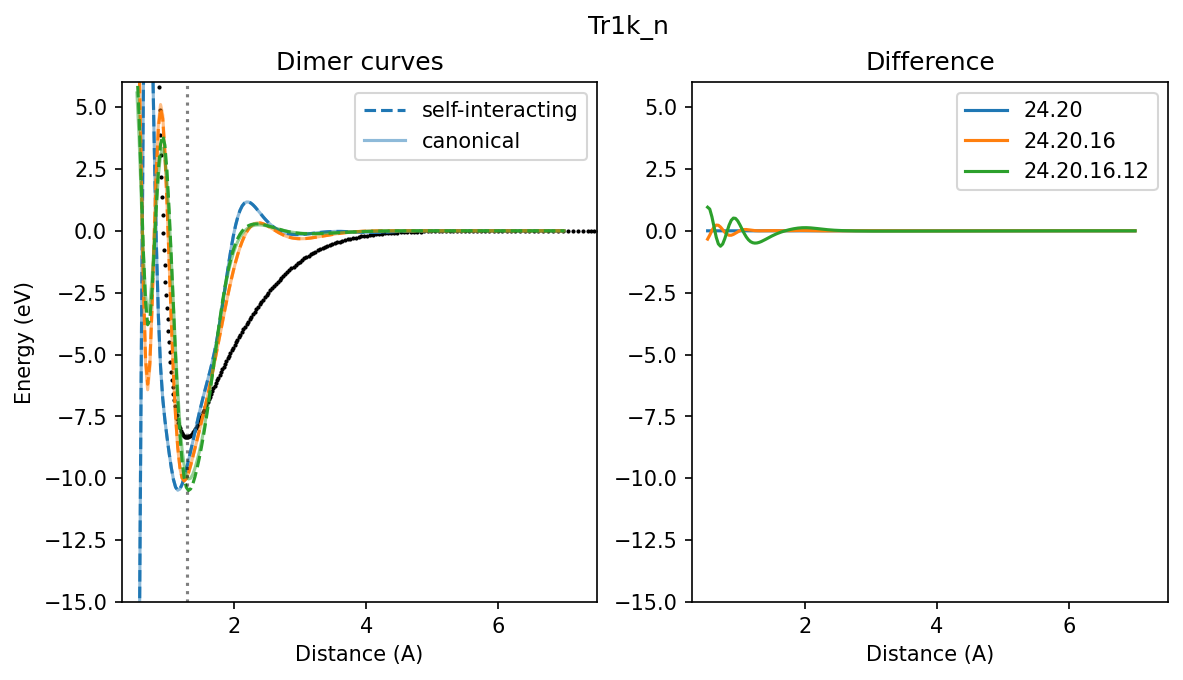

In [4]:
## Progressive convergence wrt dimgen 

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
basis_tags = ['24.20','24.20.16','24.20.16.12']
# dset = 'dimgen_247'
# dimgens = ['50','100','150','200','247']
dset = 'Tr1k_n'
jl_dims = {}
jl_puredims = {}
# basis_set = '24.20.16.12'

g, gax = plt.subplots(1,2,figsize=(9,4.5),dpi=150)
g.suptitle(f'{dset}')
# g.subplots_adjust(top=0.95)
g.subplots_adjust(wspace=0.2)
gax[0].set_title('Dimer curves')
gax[1].set_title('Difference')
gax[0].set_ylabel('Energy (eV)')
for i,basis in enumerate(basis_tags):
    jl_dims[basis] = np.loadtxt(f'{dset}'+'/'+basis+'/ecost10.0/dimercurve.dat').T
    jl_puredims[basis] = np.loadtxt(f'{dset}'+'_purify/'+basis+'/ecost10.0/dimercurve.dat').T  
    diffy = jl_dims[basis][1] - jl_puredims[basis][1]  
    if i == 0:
        gax[0].plot(*jl_dims[basis], label="self-interacting", color="C"+str(i), linestyle='--')
        gax[0].plot(*jl_puredims[basis], label="canonical", color="C"+str(i), alpha=0.5)
    else:
        gax[0].plot(*jl_dims[basis], color="C"+str(i), linestyle='--')
        gax[0].plot(*jl_puredims[basis], color="C"+str(i), alpha=0.5)
    gax[1].plot(jl_dims[basis][0], diffy, label=basis, color="C"+str(i))

for axes in gax:
    axes.set_xlim(0.3,7.5)
    axes.set_xlabel('Distance (A)')
    # axes.set_ylabel('Energy (eV)')
    axes.legend() 
gax[0].scatter(*en_qe,s=1,color='k')
gax[0].set_ylim(-15,6)
gax[1].set_ylim(-15,6)
gax[0].axvline(1.286958464, color='k', linestyle=':', alpha=0.5)



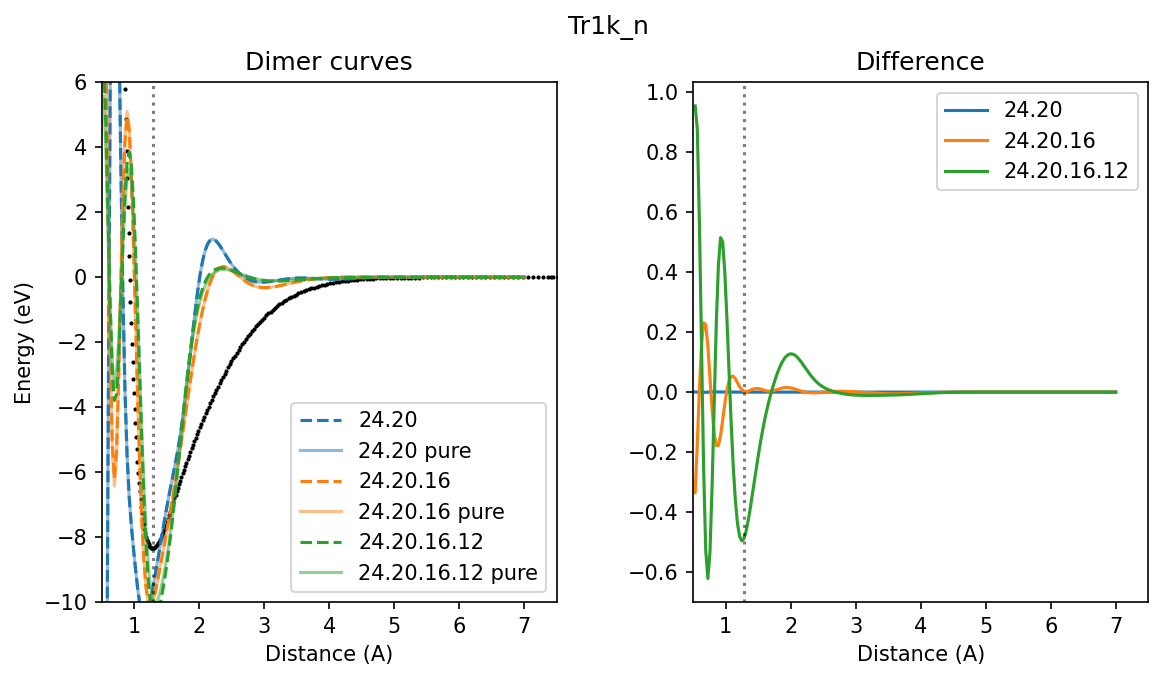

In [7]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
basis_tags = ['24.20','24.20.16','24.20.16.12']
dset = 'Tr1k_n'
dimgens = ['50','100','150','200','247']
jl_dims = {}
jl_puredims = {}

g, gax = plt.subplots(1,2,figsize=(9,4.5),dpi=150)
g.suptitle(f'{dset}')
# g.subplots_adjust(top=0.95)
g.subplots_adjust(wspace=0.3)
gax[0].set_title('Dimer curves')
gax[1].set_title('Difference')
gax[0].set_ylabel('Energy (eV)')
for i,basis in enumerate(basis_tags):
    jl_dims[basis] = np.loadtxt(f'{dset}/' + basis + f'/ecost10.0/dimercurve.dat').T
    jl_puredims[basis] = np.loadtxt(f'{dset}_purify/' + basis + f'/ecost10.0/dimercurve.dat').T  
    diffy = jl_dims[basis][1] - jl_puredims[basis][1]  

    gax[0].plot(*jl_dims[basis], label=basis, color="C"+str(i), linestyle='--')
    gax[0].plot(*jl_puredims[basis], label=basis+" pure", color="C"+str(i), alpha=0.5)
    gax[1].plot(jl_dims[basis][0], diffy, label=basis, color="C"+str(i))

for axes in gax:
    axes.set_xlim(0.5,7.5)
    axes.axvline(1.286958464, color='k', linestyle=':', alpha=0.5)
    
    axes.set_xlabel('Distance (A)')
    # axes.set_ylabel('Energy (eV)')
    axes.legend() 
gax[0].scatter(*en_qe,s=1,color='k')
gax[0].set_ylim(-10,6)
# gax[1].set_ylim(-0.1,0.1)
g.savefig('../figures/acejulia_Tr1k_n.png',bbox_inches='tight')

#### dimgen (`ACEpotentials.jl`)

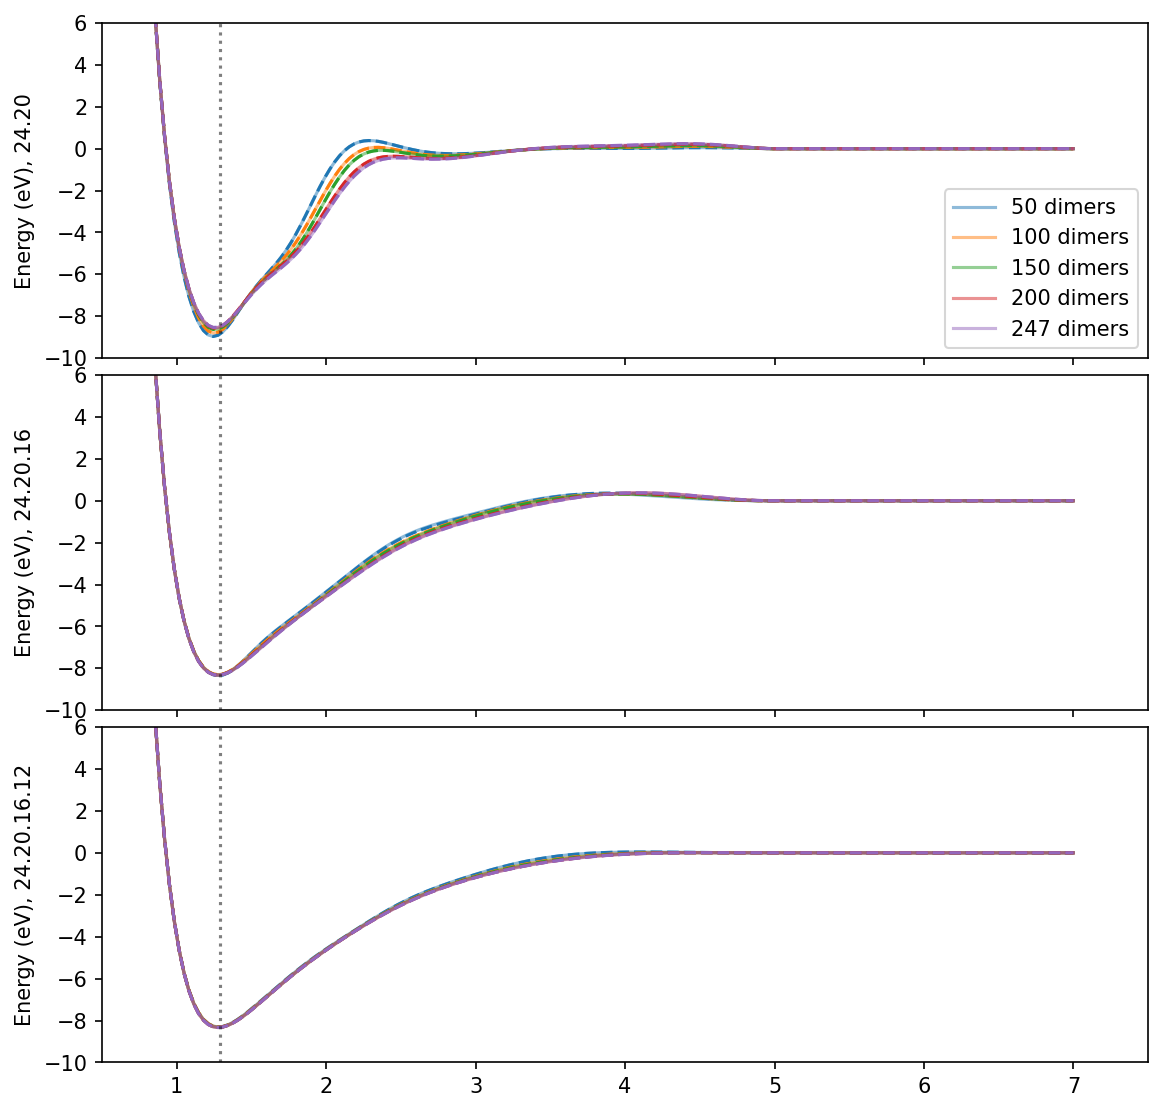

In [ ]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
# basis_tags = ['24.20','24.20.16','24.20.16.12']
# dset = 'dimgen_247'
dsets = ['dimgen_50','dimgen_100','dimgen_150','dimgen_200','dimgen_247']
dset_labels = ['50','100','150','200','247']
jl_dims = {}
jl_puredims = {}
bases = ['24.20','24.20.16','24.20.16.12']

g, gax = plt.subplots(3,1,figsize=(9,9),dpi=150, sharex=True)
g.subplots_adjust(hspace=0.05)
for i,basis in enumerate(bases):
    for j,dset in enumerate(dsets):
        jl_dims[dset + '_' + basis] = np.loadtxt(f'{dset}/' + basis + f'/ecost10.0/dimercurve.dat').T
        jl_puredims[dset + '_' + basis] = np.loadtxt(f'{dset}_purify/' + basis + f'/ecost10.0/dimercurve.dat').T
        # gax[i].plot(*jl_dims[dset + '_' + basis], label=dset, color="C"+str(j), linestyle='--')
        gax[i].plot(*jl_dims[dset + '_' + basis], color="C"+str(j), linestyle='--')
        gax[i].plot(*jl_puredims[dset + '_' + basis], label=dset_labels[j]+" dimers", color="C"+str(j), alpha=0.5)
    gax[i].set_ylabel('Energy (eV), ' + basis)
    gax[i].set_xlim(0.5,7.5)
    gax[i].axvline(1.286958464, color='k', linestyle=':', alpha=0.5)
    gax[i].set_ylim(-10,6)
gax[0].legend()
gax[3].set_xlabel('Distance (A)')

g.savefig('../figures/dimgen_acejl.png',dpi=300,bbox_inches='tight')

(-0.1, 0.1)

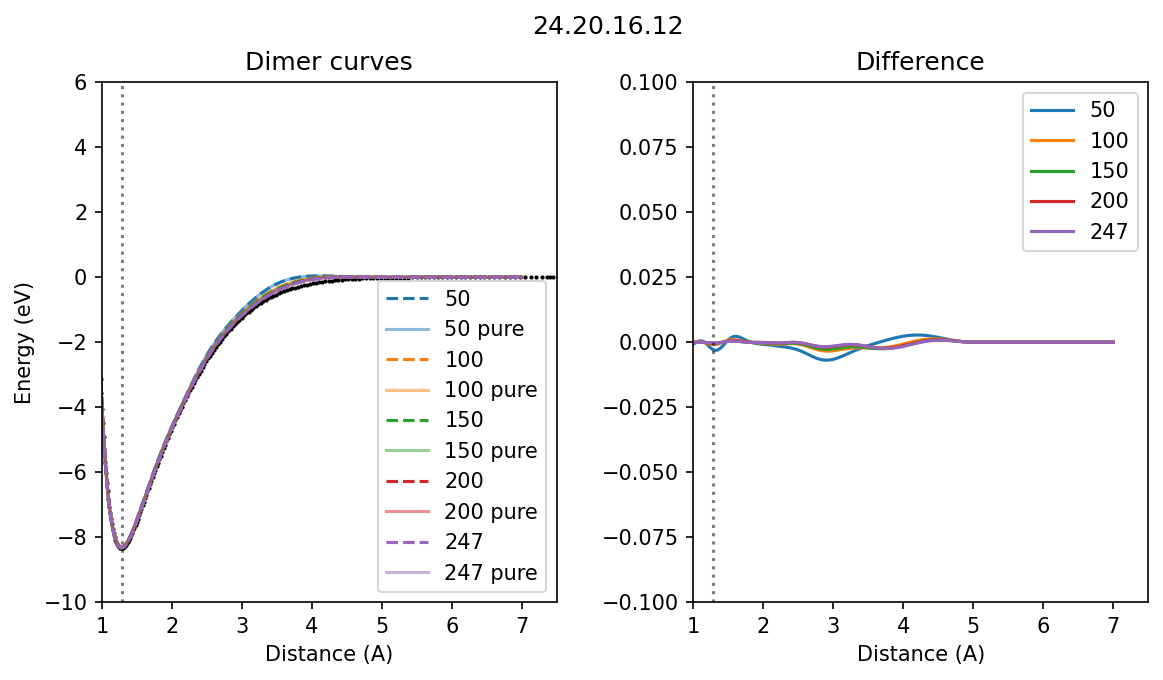

In [13]:
## Progressive convergence wrt dimgen 

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
# basis_tags = ['24.20','24.20.16','24.20.16.12']
# dset = 'dimgen_247'
dimgens = ['50','100','150','200','247']
jl_dims = {}
jl_puredims = {}
basis_set = '24.20.16.12'

g, gax = plt.subplots(1,2,figsize=(9,4.5),dpi=150)
g.suptitle(basis_set)
# g.subplots_adjust(top=0.95)
g.subplots_adjust(wspace=0.3)
gax[0].set_title('Dimer curves')
gax[1].set_title('Difference')
gax[0].set_ylabel('Energy (eV)')
# for i,basis in enumerate(basis_tags):
for i,dimgen in enumerate(dimgens):
    jl_dims[dimgen] = np.loadtxt('dimgen_'+f'{dimgen}'+'/'+basis_set+'/ecost10.0/dimercurve.dat').T
    jl_puredims[dimgen] = np.loadtxt('dimgen_'+f'{dimgen}'+'_purify/'+basis_set+'/ecost10.0/dimercurve.dat').T  
    diffy = jl_dims[dimgen][1] - jl_puredims[dimgen][1]  

    gax[0].plot(*jl_dims[dimgen], label=dimgen, color="C"+str(i), linestyle='--')
    gax[0].plot(*jl_puredims[dimgen], label=dimgen+" pure", color="C"+str(i), alpha=0.5)
    gax[1].plot(jl_dims[dimgen][0], diffy, label=dimgen, color="C"+str(i))

for axes in gax:
    axes.set_xlim(1,7.5)
    axes.axvline(1.286958464, color='k', linestyle=':', alpha=0.5)
    
    axes.set_xlabel('Distance (A)')
    # axes.set_ylabel('Energy (eV)')
    axes.legend() 
gax[0].scatter(*en_qe,s=1,color='k')
gax[0].set_ylim(-10,6)
gax[1].set_ylim(-0.1,0.1)



(-0.1, 0.1)

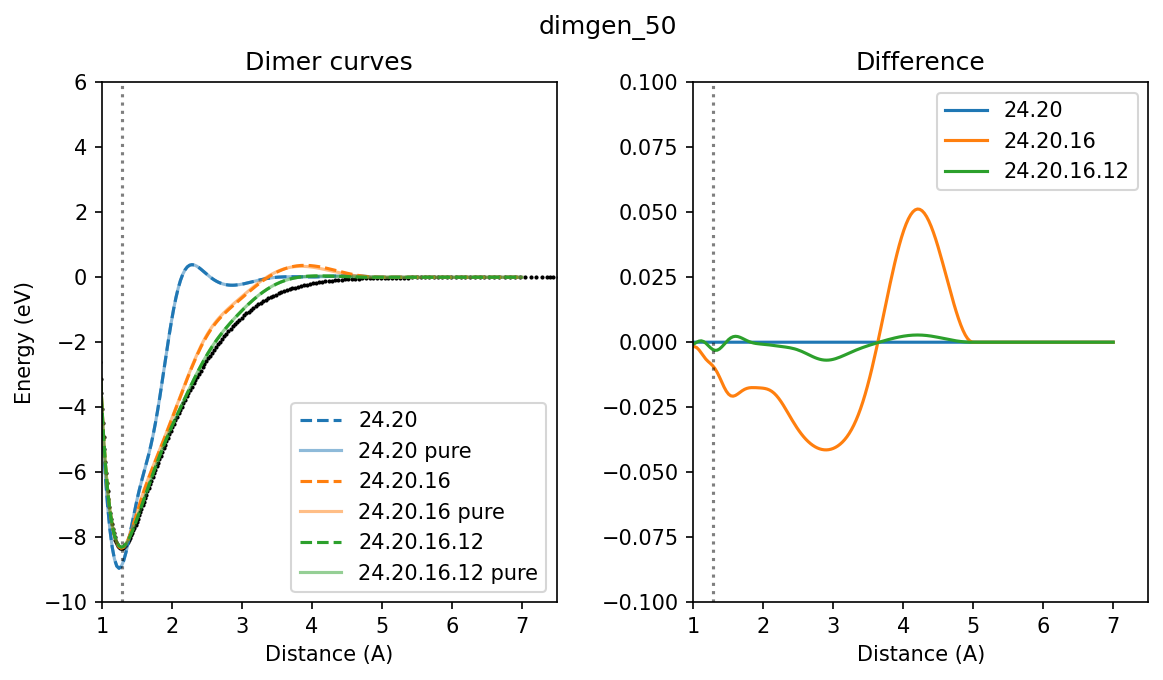

In [ ]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# basis_tags = ['16.12','46.16','16.12.8','16.12.8.4']
basis_tags = ['24.20','24.20.16','24.20.16.12']
dset = 'dimgen_247'
dimgens = ['50','100','150','200','247']
jl_dims = {}
jl_puredims = {}

g, gax = plt.subplots(1,2,figsize=(9,4.5),dpi=150)
g.suptitle(f'{dset}')
# g.subplots_adjust(top=0.95)
g.subplots_adjust(wspace=0.3)
gax[0].set_title('Dimer curves')
gax[1].set_title('Difference')
gax[0].set_ylabel('Energy (eV)')
for i,basis in enumerate(basis_tags):
    jl_dims[basis] = np.loadtxt(f'{dset}/' + basis + f'/ecost10.0/dimercurve.dat').T
    jl_puredims[basis] = np.loadtxt(f'{dset}_purify/' + basis + f'/ecost10.0/dimercurve.dat').T  
    diffy = jl_dims[basis][1] - jl_puredims[basis][1]  

    gax[0].plot(*jl_dims[basis], label=basis, color="C"+str(i), linestyle='--')
    gax[0].plot(*jl_puredims[basis], label=basis+" pure", color="C"+str(i), alpha=0.5)
    gax[1].plot(jl_dims[basis][0], diffy, label=basis, color="C"+str(i))

for axes in gax:
    axes.set_xlim(1,7.5)
    axes.axvline(1.286958464, color='k', linestyle=':', alpha=0.5)
    
    axes.set_xlabel('Distance (A)')
    # axes.set_ylabel('Energy (eV)')
    axes.legend() 
gax[0].scatter(*en_qe,s=1,color='k')
gax[0].set_ylim(-10,6)
gax[1].set_ylim(-0.1,0.1)

#### (LSQR results) Basis + tolerance

IndexError: list index out of range

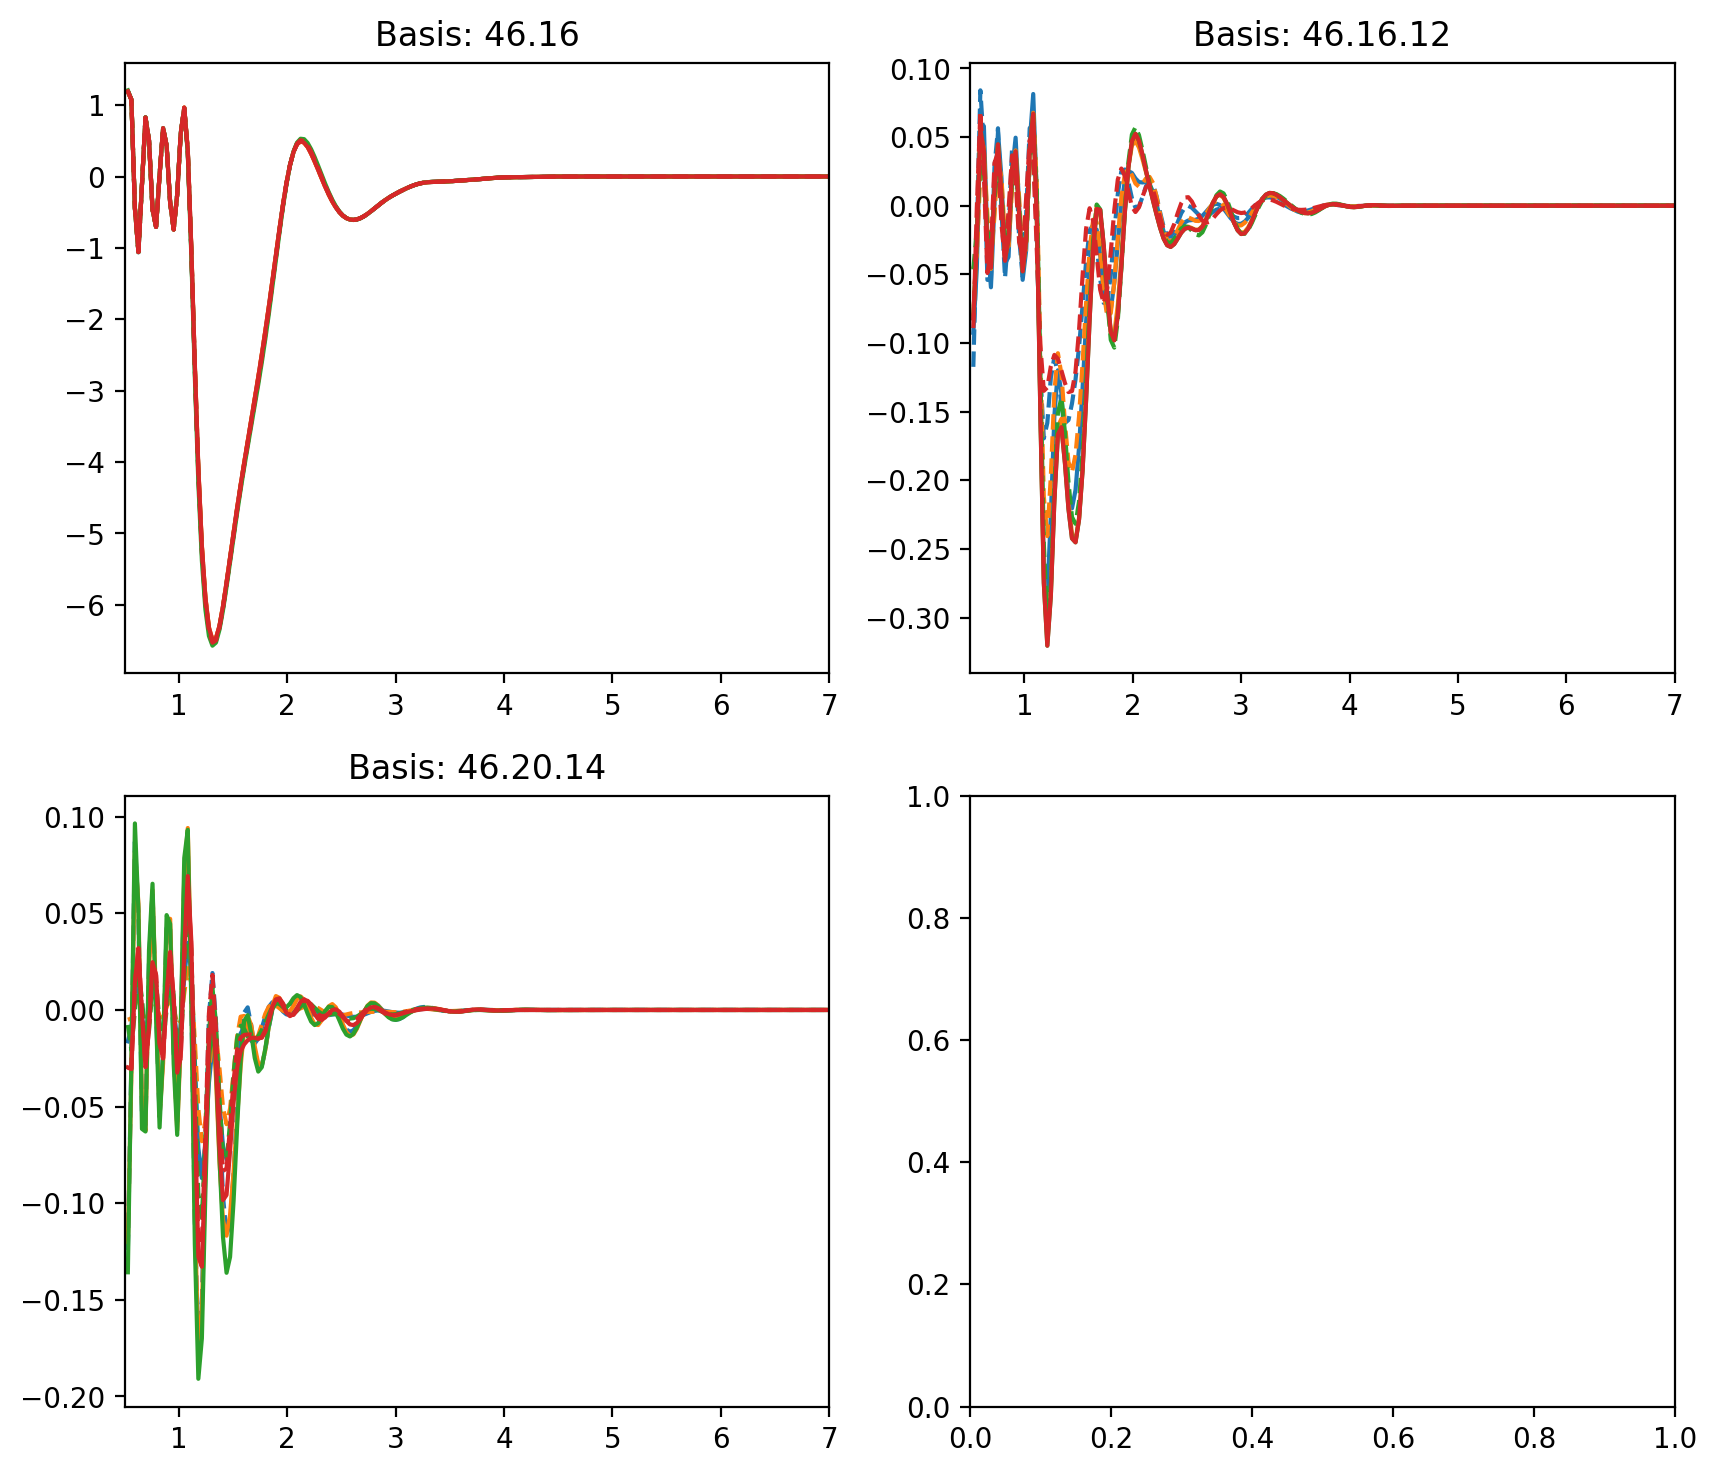

In [5]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
# self-interacting
# basis_tags = ['46.16', '46.16.12', '46.20.14', '46.24.16', '46.20.14.10']
basis_tags = ['46.16', '46.16.12', '46.20.14']
tolerances = ['1.0e-15', '1.0e-9', '5.0e-9', '1.0e-8']
# tolerances = ['1.0e-8']
dset = 'Tr100_n'
jl_dims = {}
jl_puredims = {}

for basis in basis_tags:
    jl_puredims[basis] = {}
    jl_dims[basis] = {}
    for i,tol in enumerate(tolerances):
        jl_dims[basis][tol] = np.loadtxt(f'{dset}/' + basis + f'/ecost50.0/damp{tol}/dimercurve.dat').T
        jl_puredims[basis][tol] = np.loadtxt(f'{dset}_purify/' + basis + f'/ecost50.0/damp{tol}/dimercurve.dat').T

g, gax = plt.subplots(2, 2, figsize=(10, 8),dpi=200)
g.subplots_adjust(top=0.95)
# for tags in jl_puredims['46.16']:
#     tolval = tags
#     dimers = jl_puredims['46.16'][tags]
#     gax[0,0].plot(*dimers, label='tol='+tolval)

for i,axes in enumerate(gax.flatten()):
    axes.set_title(f'Basis: {basis_tags[i]}')
    for j,tol in enumerate(tolerances):
        axes.plot(*jl_dims[basis_tags[i]][tol], ls='--', label='ACE'+tol, color='C'+str(j))
        axes.plot(*jl_puredims[basis_tags[i]][tol], label='pure'+tol, color='C'+str(j))
    # axes.plot(*jl_puredims[basis_tags[i]]['1.0e-15'], label='tol=1.0e-15')
    axes.set_xlim(0.5, 7)
    # axes.set_ylim(-10, 6)
    # axes.set_ylim(-0.5,0.5)
    # if i==3:
        # axes.scatter(*en_qe, s=1, color='k', label='DFT')
    # else:
        # axes.scatter(*en_qe, s=1, color='k')
gax[1,1].legend(loc='upper right')

### Original

(-12.0, 10.0)

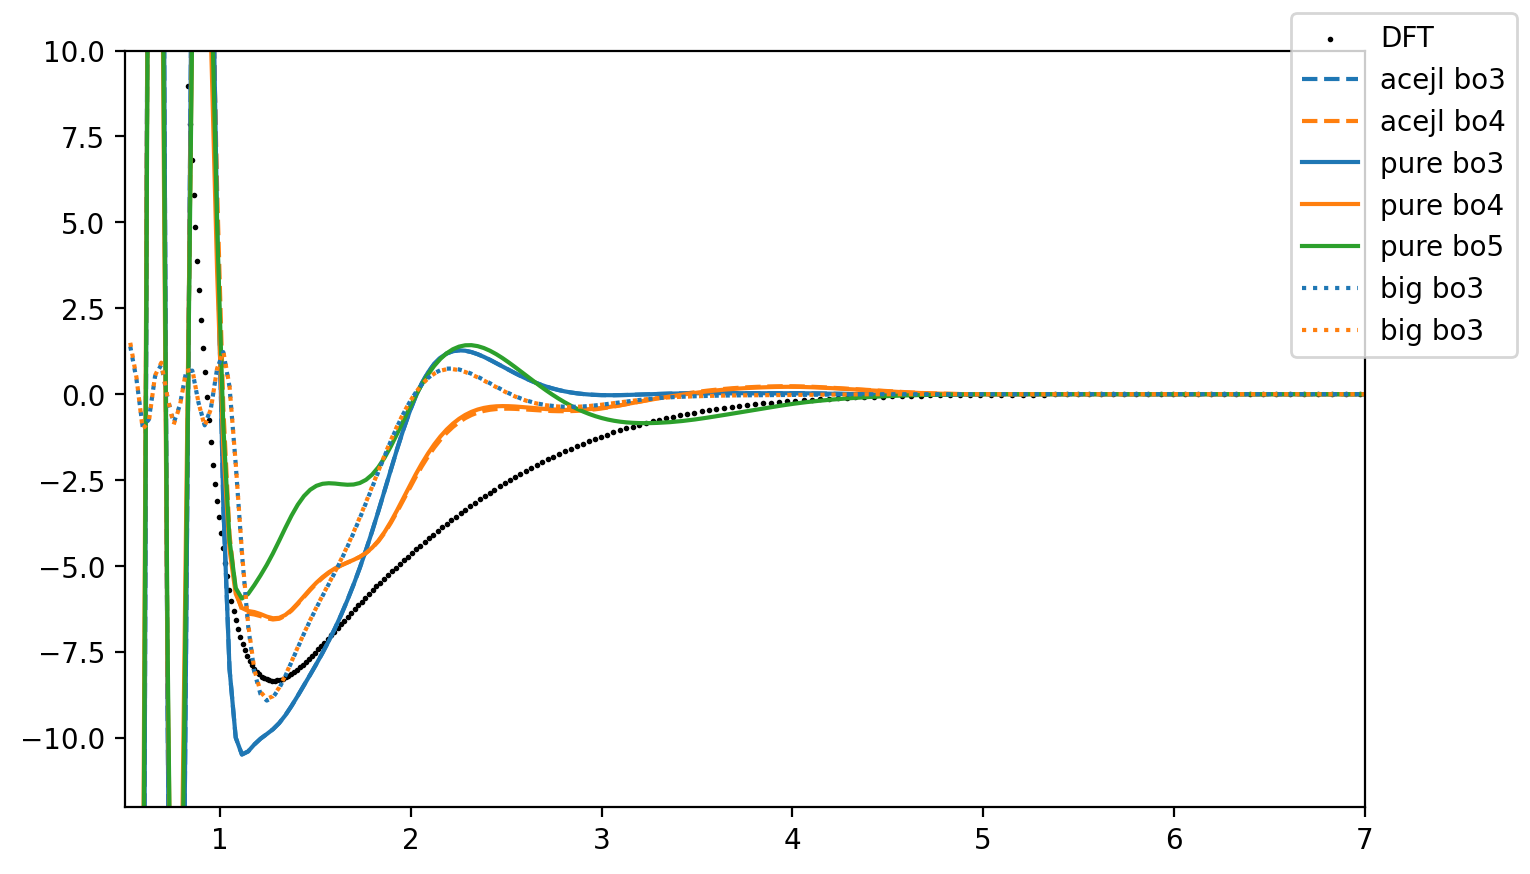

In [62]:
## Data loading ## 
os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(1,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

# acejl
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
acejl_Tr1k_n_border3 = np.loadtxt('Tr1k_n/border3/dimercurve.dat').T
acejl_Tr1k_n_border4 = np.loadtxt('Tr1k_n/border4/dimercurve.dat').T
qwer = np.loadtxt('Tr1k_n/46.16/ecost50.0/damp1.0e-8/dimercurve.dat').T
acejl_Tr1k_n_curves = [acejl_Tr1k_n_border3, acejl_Tr1k_n_border4]
pure_Tr1k_n_border3 = np.loadtxt('Tr1k_n_purify/border3/dimercurve.dat').T
pure_Tr1k_n_border4 = np.loadtxt('Tr1k_n_purify/border4/dimercurve.dat').T
pure_Tr1k_n_border5 = np.loadtxt('Tr1k_n_purify/border5/dimercurve.dat').T
qwer_pure = np.loadtxt('Tr1k_n_purify/46.16/ecost50.0/damp1.0e-8/dimercurve.dat').T
pure_Tr1k_n_curves = [pure_Tr1k_n_border3, pure_Tr1k_n_border4, pure_Tr1k_n_border5]
bigborder3 = [qwer, qwer_pure]

# pacemaker
os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/pacemaker/Tr1k_n/border')
bordervals = ["2","3","4"]
pacemaker_potdirs = ['b_order'+border+'/' for border in bordervals]

## Plotting ##
g,gax = plt.subplots(1,1,figsize=(8,4.5), dpi=200)
g.subplots_adjust(top=0.95)
gax.scatter(*en_qe,s=1,color='k',label='DFT')

# pacemaker
# for i, dir in enumerate(pacemaker_potdirs):
#     gax.plot(r, en_ase(r, dir, 'output_potential.yaml'), label=r'pace bo'+bordervals[i], color=cm.twilight(0.7-0.7*i/3), alpha=0.5)

# ACE-JL
for j,acejl in enumerate(acejl_Tr1k_n_curves):
    gax.plot(*acejl, color='C'+str(j), ls = '--', label=r'acejl bo'+str(j+3))

for j,acejl in enumerate(pure_Tr1k_n_curves):
    gax.plot(*acejl, color='C'+str(j), linestyle='-', label=r'pure bo'+str(j+3))

for j,acejl in enumerate(bigborder3):
    gax.plot(*acejl, color='C'+str(j), linestyle=':', label=r'big bo3')

g.legend()
gax.set_xlim(0.5,7)
gax.set_ylim(-12,10)

## Silicon 

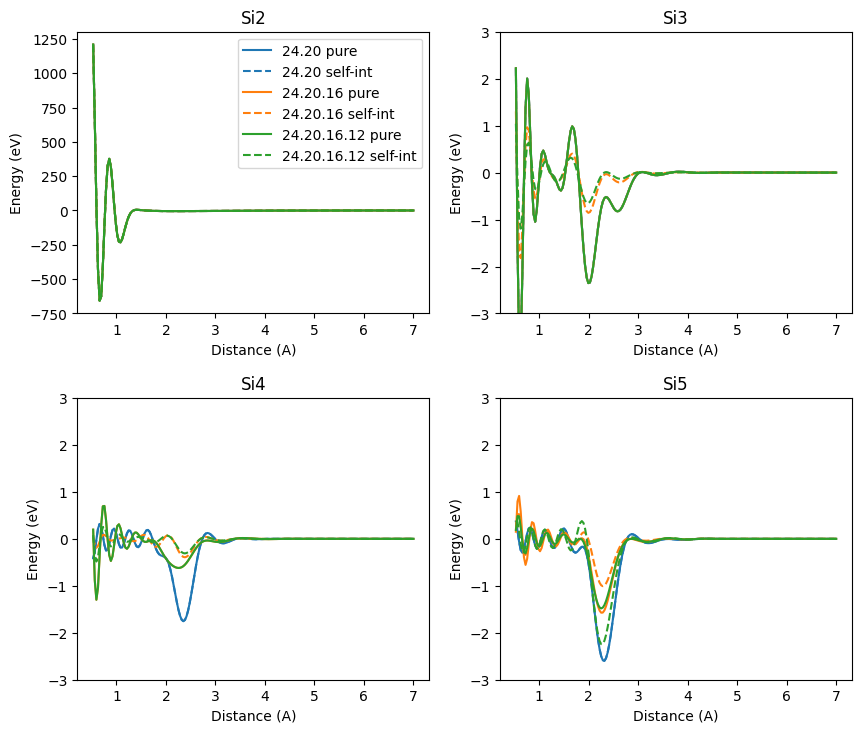

In [30]:
os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(1,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia/')
g, gax = plt.subplots(2, 2, figsize=(10, 8), dpi=100)
g.subplots_adjust(top=0.92, hspace=0.3)
basis_tags = ['24.20', '24.20.16', '24.20.16.12']
ecost = 10.0
dsets = ['Si2', 'Si3', 'Si4', 'Si5']
Si_pure = {}
Si_selfint = {}

axes_flat = gax.flatten()
for i, dset in enumerate(dsets):
    axes_flat[i].set_title(dset)
    for j, basis in enumerate(basis_tags):
        Si_pure[dset+'_'+basis] = np.loadtxt(f'{dset}_purify/' + basis + f'/ecost{ecost}/dimercurve.dat').T
        Si_selfint[dset+'_'+basis] = np.loadtxt(f'{dset}/' + basis + f'/ecost{ecost}/dimercurve.dat').T
        axes_flat[i].plot(*Si_pure[dset+'_'+basis], label=basis+' pure', color='C'+str(j), linestyle='-')
        axes_flat[i].plot(*Si_selfint[dset+'_'+basis], label=basis+' self-int', color='C'+str(j), linestyle='--')

axes_flat[0].legend(loc='upper right')

for axes in axes_flat:
    axes.set_xlabel('Distance (A)')
    axes.set_ylabel('Energy (eV)')
    if axes != axes_flat[0]:
        axes.set_ylim(-3,3)

plt.savefig("../figures/Si_dimer_curves.png", bbox_inches="tight") 

# Others

## Loss balancing, with dimer energy

### Original loss balancing

(350.0, 600.0)

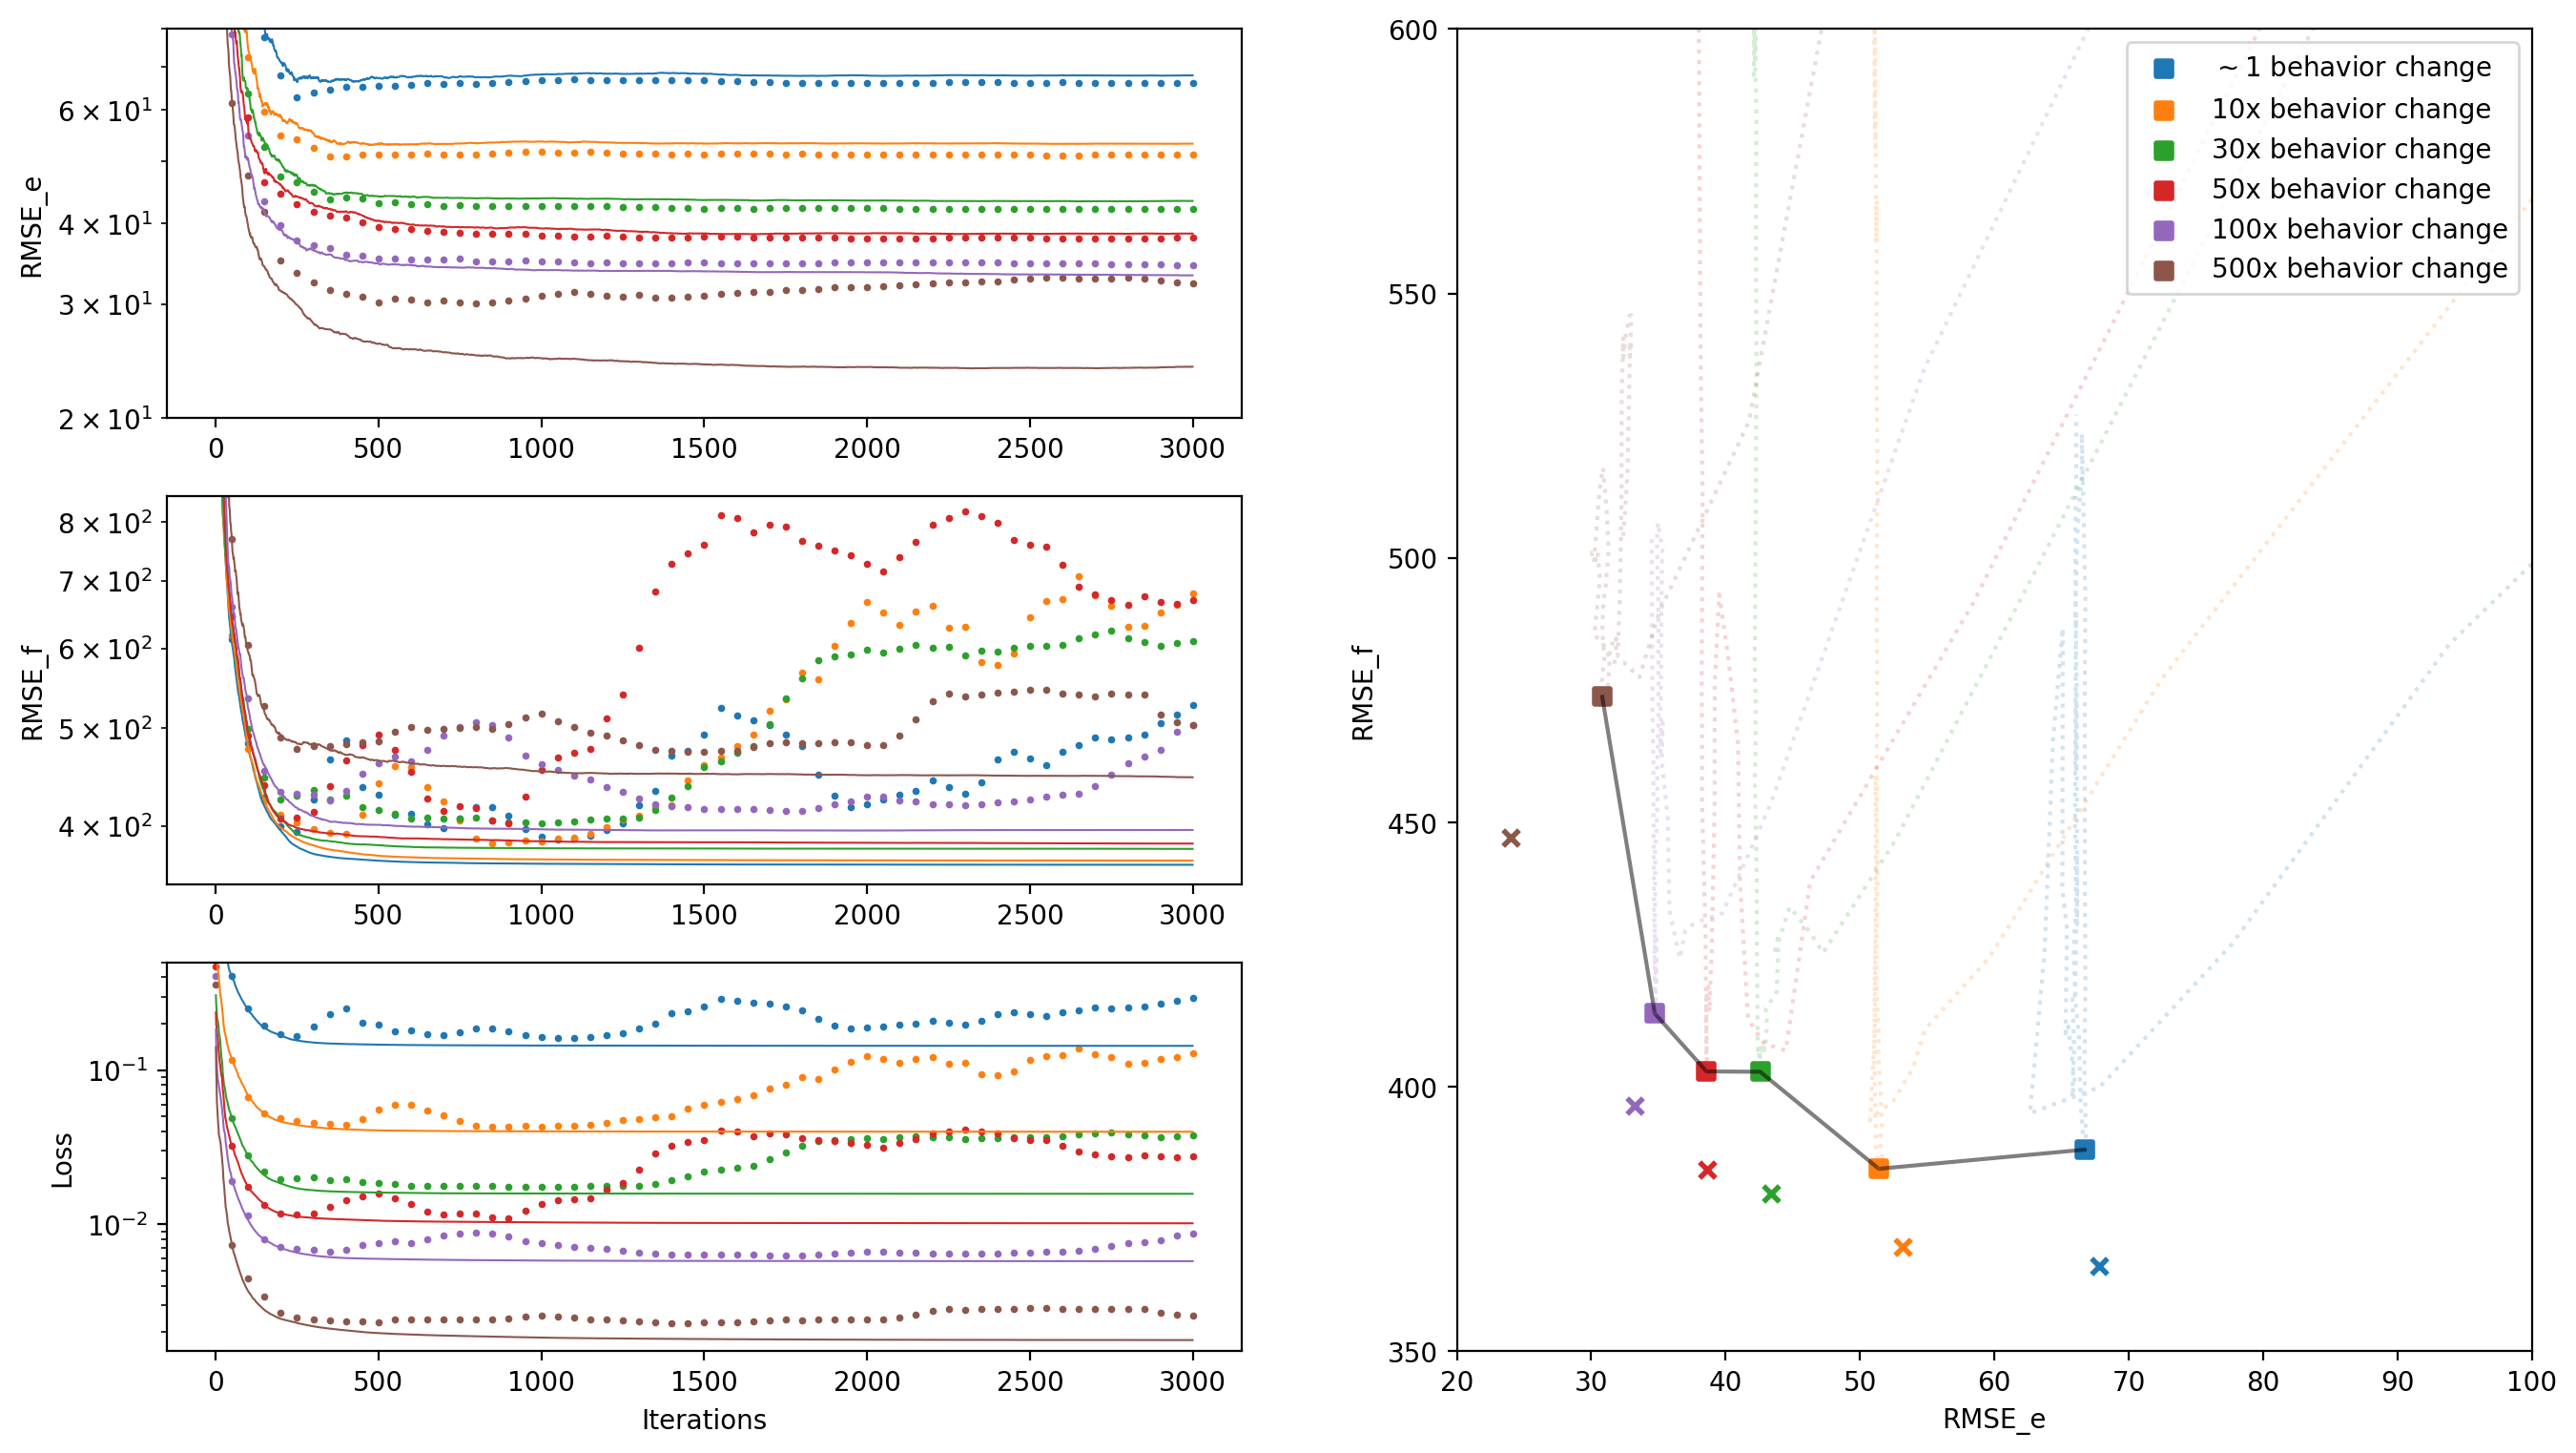

In [4]:
# Data loading
datadir = 'datafiles/Tr1k_n/'
kappa_list = ['1shot_1kval','kappa10times','kappa30times', 'kappa50times', 'kappa100times', 'kappa500times']
kappa_labels = [f'$\sim 1$', '10x', '30x', '50x', '100x', '500x']

kappa_itertrain = np.array([np.loadtxt(datadir+kappa+'/b_order4/lrnrate.dat').T for kappa in kappa_list]) # original is (entry, (iter,loss,rmse_e,rmse_f),iter)
kappa_iterval = np.array([np.loadtxt(datadir+kappa+'/b_order4/vallrn_l.dat').T for kappa in kappa_list]) # iter, loss
iterval_ef = np.array([np.loadtxt(datadir+kappa+'/b_order4/vallrn_ef.dat').T for kappa in kappa_list]) # rmse_e, rmse_f

# original is (Nf, loss, rmse_e, rmse_f)
kappa_trainerr = np.array([np.loadtxt(datadir+kappa+'/b_order4/train_rmse.dat').T for kappa in kappa_list]) 
kappa_testerr = np.array([np.loadtxt(datadir+kappa+'/b_order4/test_rmse.dat').T for kappa in kappa_list])

# identical for all runs 
iters = kappa_itertrain[0,0,:] # training iterations
iters_val = kappa_iterval[0][0] # validation iterations
iterval_ef_norm = np.linalg.norm(iterval_ef, axis=1) # norms of validation errors for Le, Lf

# Index and "coordinates" of minimal validation error 
overfit_ind = np.argmin(iterval_ef_norm, axis=1)

iterval_ef_of = np.array([iterval_ef[i,:,overfit_ind[i]] for i in range(len(overfit_ind))])


f = plt.figure(figsize=(16,9),dpi=200)

axle = f.add_subplot(321); axlf = f.add_subplot(323); axl = f.add_subplot(325)
lax = [axle,axlf,axl]
axlelf = f.add_subplot(122)
for ax in lax:
    ax.set_yscale('log')

for i,loss in enumerate(kappa_itertrain[:,2,:]):
    axle.plot(iters,loss,lw=0.75)
    axle.scatter(iters_val,iterval_ef[i,0],s=3)
axle.set_ylim(20,80)
axle.set_ylabel('RMSE_e')

for i,loss in enumerate(kappa_itertrain[:,3,:]):
    axlf.plot(iters,loss,lw=0.75)
    axlf.scatter(iters_val,iterval_ef[i,1],s=3)
axlf.set_ylim(350,850)
axlf.set_ylabel('RMSE_f')

for i,loss in enumerate(kappa_itertrain[:,1,:]):
    axl.plot(iters,loss,lw=0.75)
    axl.scatter(iters_val,kappa_iterval[i,1],s=3)
axl.set_ylim(1.5e-3,5e-1)
axl.set_ylabel('Loss')
axl.set_xlabel('Iterations')

for i,trainerr in enumerate(kappa_trainerr):
    # axlelf.scatter(*trainerr[1:3]*1e3, label=kappa_labels[i], color='C'+str(i), marker='x', linewidth=2)
    axlelf.scatter(*trainerr[1:3]*1e3, label='_', color='C'+str(i), marker='x', linewidth=2)

axlelf.plot(*iterval_ef_of.T,'k-',alpha=0.5)
for i,testerr in enumerate(iterval_ef_of):
    axlelf.scatter(*testerr, label=kappa_labels[i]+' behavior change', color='C'+str(i), marker='s',linewidth=2)
for k,errtraj in enumerate(iterval_ef):
    axlelf.plot(*errtraj,':',color='C'+str(k),alpha=0.2)


# for i,testerr in enumerate(kappa_testerr):
#     axlelf.scatter(*testerr[1:3], label=kappa_labels[i]+' test', color='C'+str(i), linewidth=2)
axlelf.legend(loc='upper right')
axlelf.set_ylabel('RMSE_f')
axlelf.set_xlabel('RMSE_e')
axlelf.set_xlim(20,100); axlelf.set_ylim(350,600)
# axlelf.set_yscale('log')
# axlelf.set_xscale('log')

### Early cut loss balancing

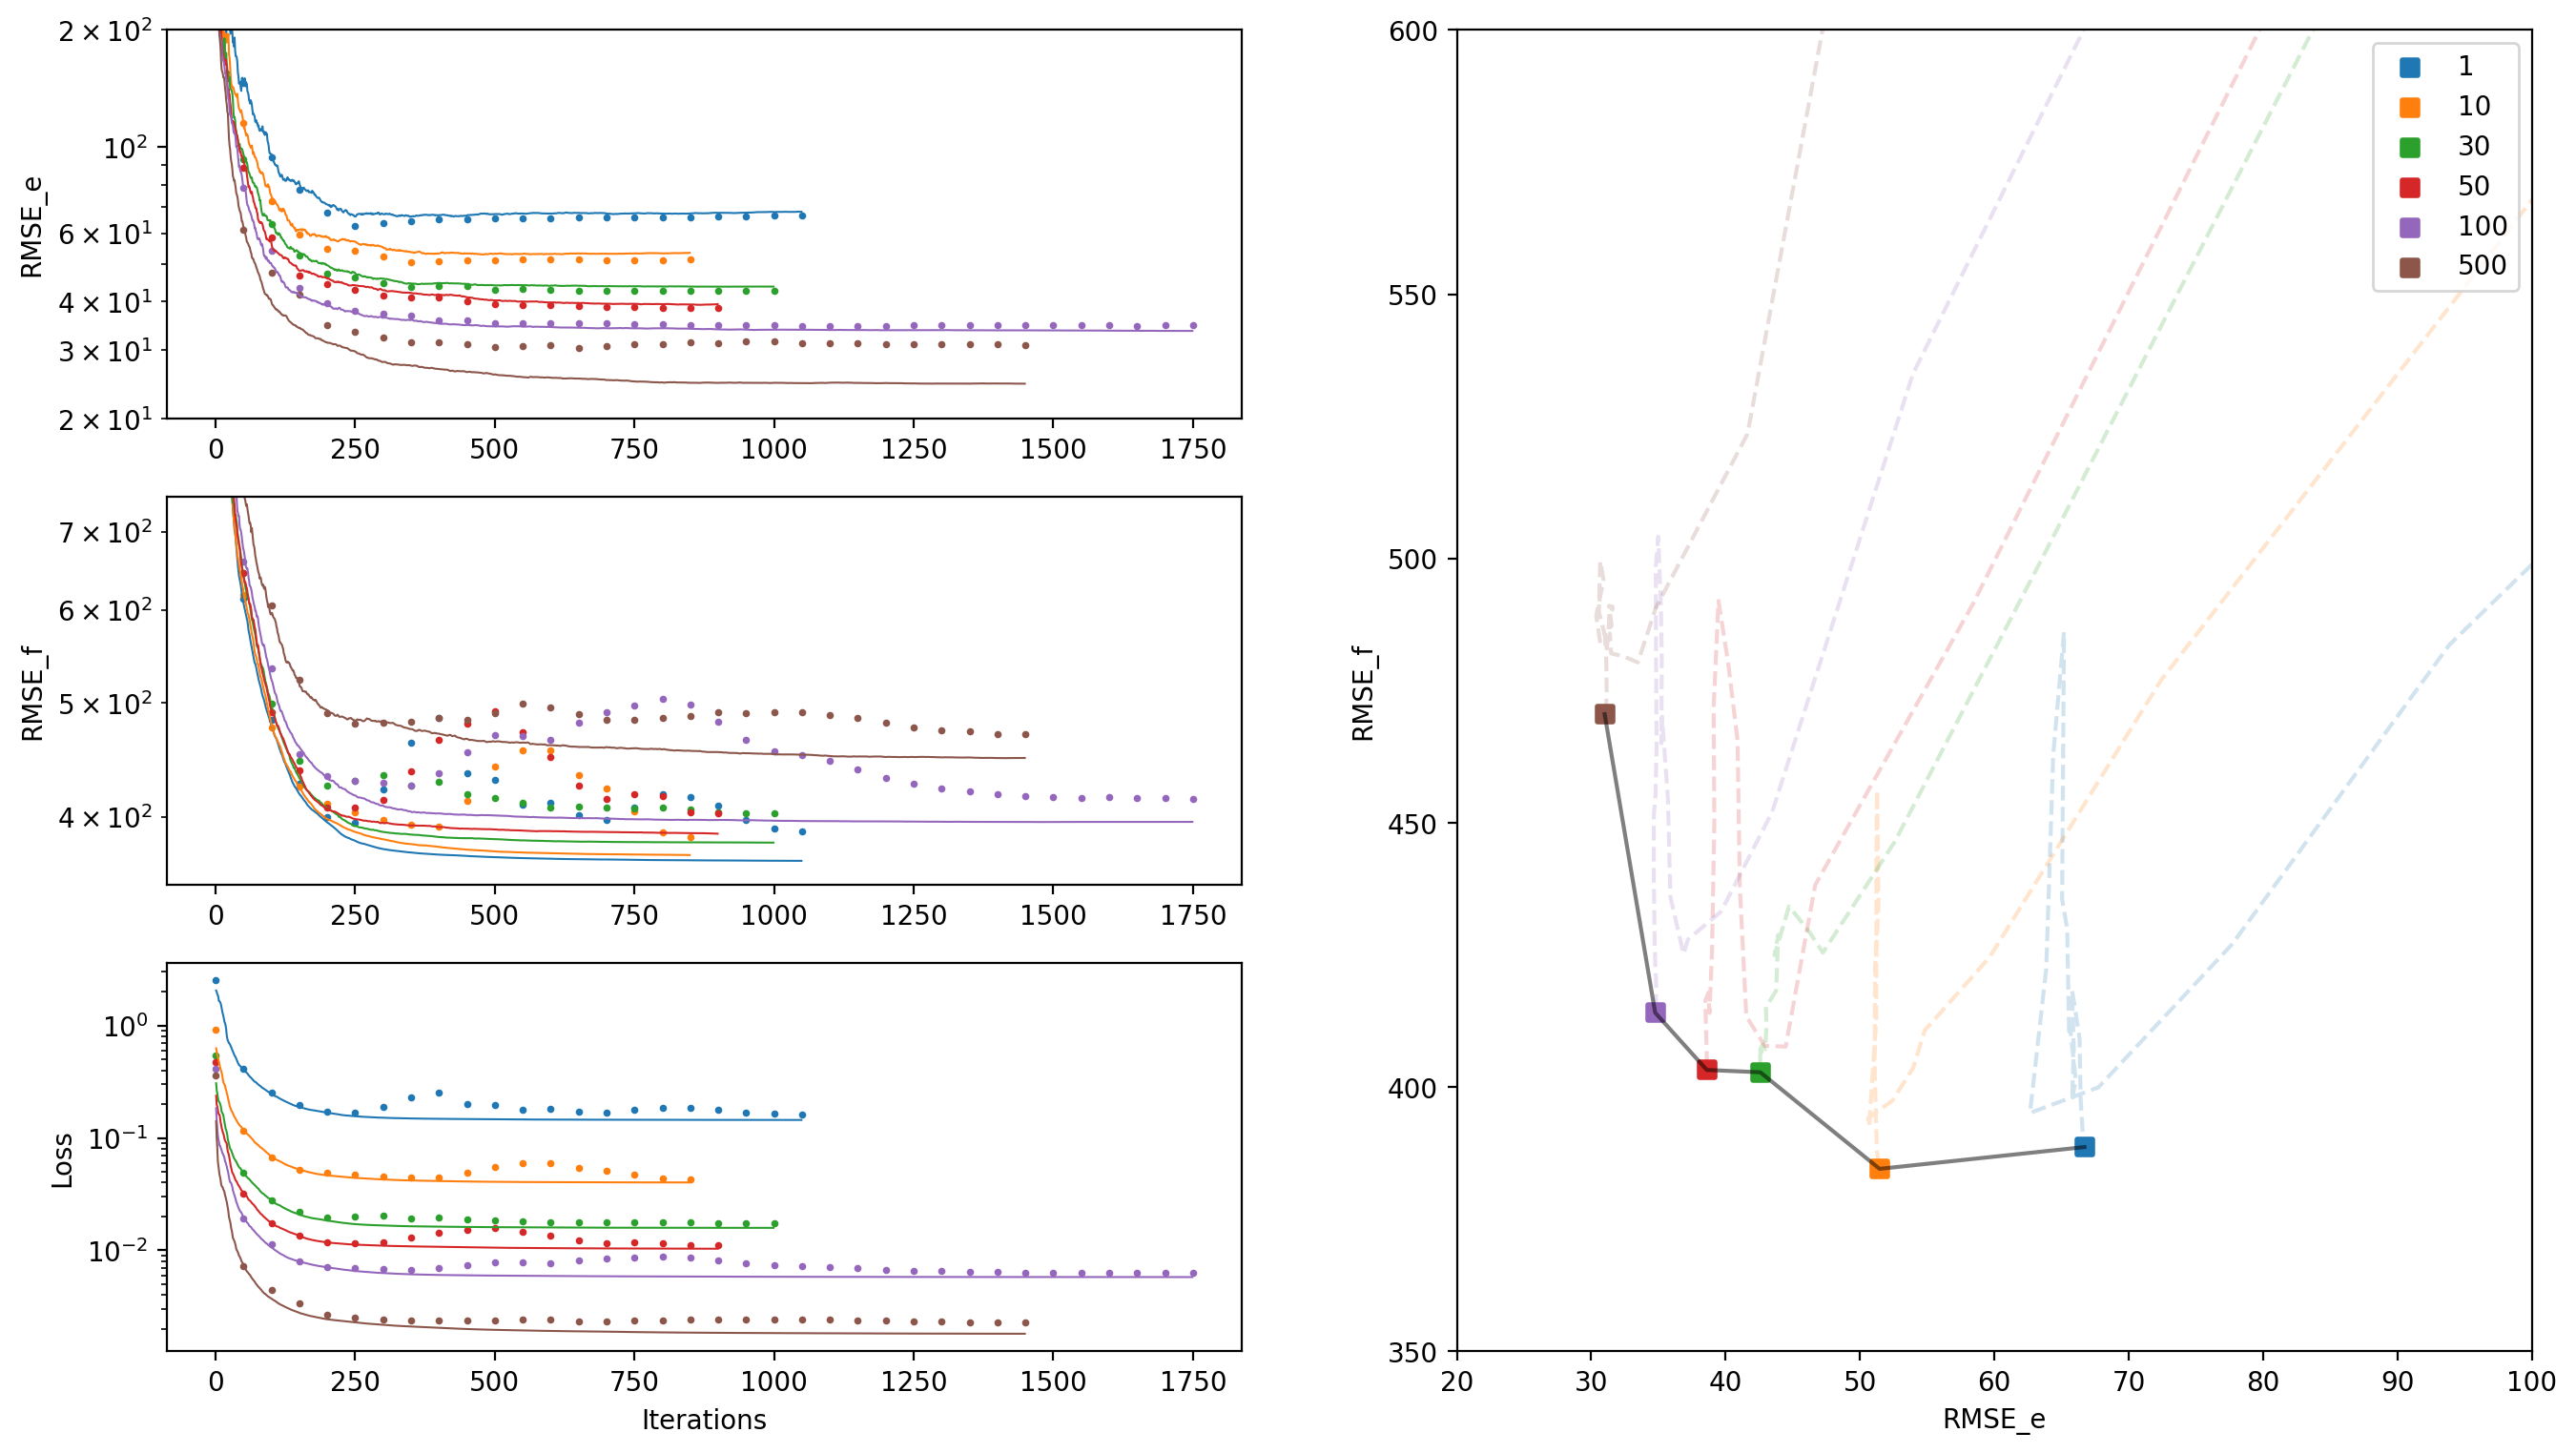

In [ ]:
# Data loading
datadir = 'datafiles_response/Tr1k_n/'
kappavals = [1, 10, 30, 50, 100, 500]
trainloss = [np.loadtxt(datadir+'kappa'+str(kappa)+'/trainloss.dat').T for kappa in kappavals] # original is (entry, (iter,loss,rmse_e,rmse_f),iter)
valloss = [np.loadtxt(datadir+'kappa'+str(kappa)+'/valloss.dat').T for kappa in kappavals] # (entry,iter,loss,rmse_e,rmse_f)

# Plotting
f = plt.figure(figsize=(16,9),dpi=200)
axle = f.add_subplot(321); axlf = f.add_subplot(323); axl = f.add_subplot(325)
lax = [axl,axle,axlf]
axlelf = f.add_subplot(122)
for i,ax in enumerate(lax):
    for j,loss in enumerate(trainloss):
        ax.plot(loss[0],loss[i+1],lw=0.75)
        ax.scatter(valloss[j][0],valloss[j][i+1],s=3)
    ax.set_yscale('log')

axlelf_connectors = []
for k,errs in enumerate(valloss):
    axlelf.scatter(*errs[-2:][:,-1],label=kappavals[k],color='C'+str(k),marker='s',linewidth=2)
    axlelf_connectors.append([errs[-2:][:,-1][0], errs[-2:][:,-1][1]])
    axlelf.plot(*errs[-2:],color='C'+str(k),linestyle='--',alpha=0.2)

axlelf.plot(*np.array(axlelf_connectors).T,'k-',alpha=0.5)

axle.set_ylim(20,200)
axlf.set_ylim(350,750)
axlelf.set_ylim(350,600)
axlelf.set_xlim(20,100)
axlelf.set_ylabel('RMSE_f')
axlelf.set_xlabel('RMSE_e')
axlelf.legend(loc='upper right')
axle.set_ylabel('RMSE_e')
axlf.set_ylabel('RMSE_f')
axl.set_ylabel('Loss')
axl.set_xlabel('Iterations')

f.savefig('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/figures/loss_balancing.png', bbox_inches='tight')

### Dimer curves

In [1]:
# Directories
datadir = 'datafiles_response/Tr1k_n/'
kappavals = [1, 10, 30, 50, 100, 500]
vals = ['kappa'+str(k) for k in kappavals]
potdirs = [datadir+v+'/' for v in vals]
potname = 'interim_potential_0.yaml'

# Data loading
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV
r = en_qe[0]

g,ax = plt.subplots(1,1,figsize=(8,4.5),dpi=200)
ax.scatter(*en_qe,s=1,color='k')
for i, potdir in enumerate(potdirs):
    ax.plot(r, en_ase(r,potdir,potname),label=kappavals[i])
ax.legend(loc='upper right')
ax.set_xlim(1.028616,6)
ax.set_ylim(-10,8)
ax.set_ylabel('Energy (eV)')
ax.set_xlabel('Distance (A)')

g.savefig('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/figures/loss_balancing_dimcurves.png',bbox_inches='tight')

NameError: name 'np' is not defined

## Relabeling with strictly 2-body energy

In [8]:
os.getcwd()

'/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/acejulia'

In [21]:
bins

array([1.13912078, 1.21633823, 1.29355568, 1.37077314, 1.44799059,
       1.52520804, 1.60242549, 1.67964294, 1.75686039, 1.83407785,
       1.9112953 , 1.98851275, 2.0657302 , 2.14294765, 2.2201651 ,
       2.29738256, 2.37460001, 2.45181746, 2.52903491, 2.60625236,
       2.68346981, 2.76068727, 2.83790472, 2.91512217, 2.99233962,
       3.06955707, 3.14677452, 3.22399198, 3.30120943, 3.37842688,
       3.45564433, 3.53286178, 3.61007923, 3.68729669, 3.76451414,
       3.84173159, 3.91894904, 3.99616649, 4.07338394, 4.1506014 ,
       4.22781885, 4.3050363 , 4.38225375, 4.4594712 , 4.53668865,
       4.61390611, 4.69112356, 4.76834101, 4.84555846, 4.92277591])

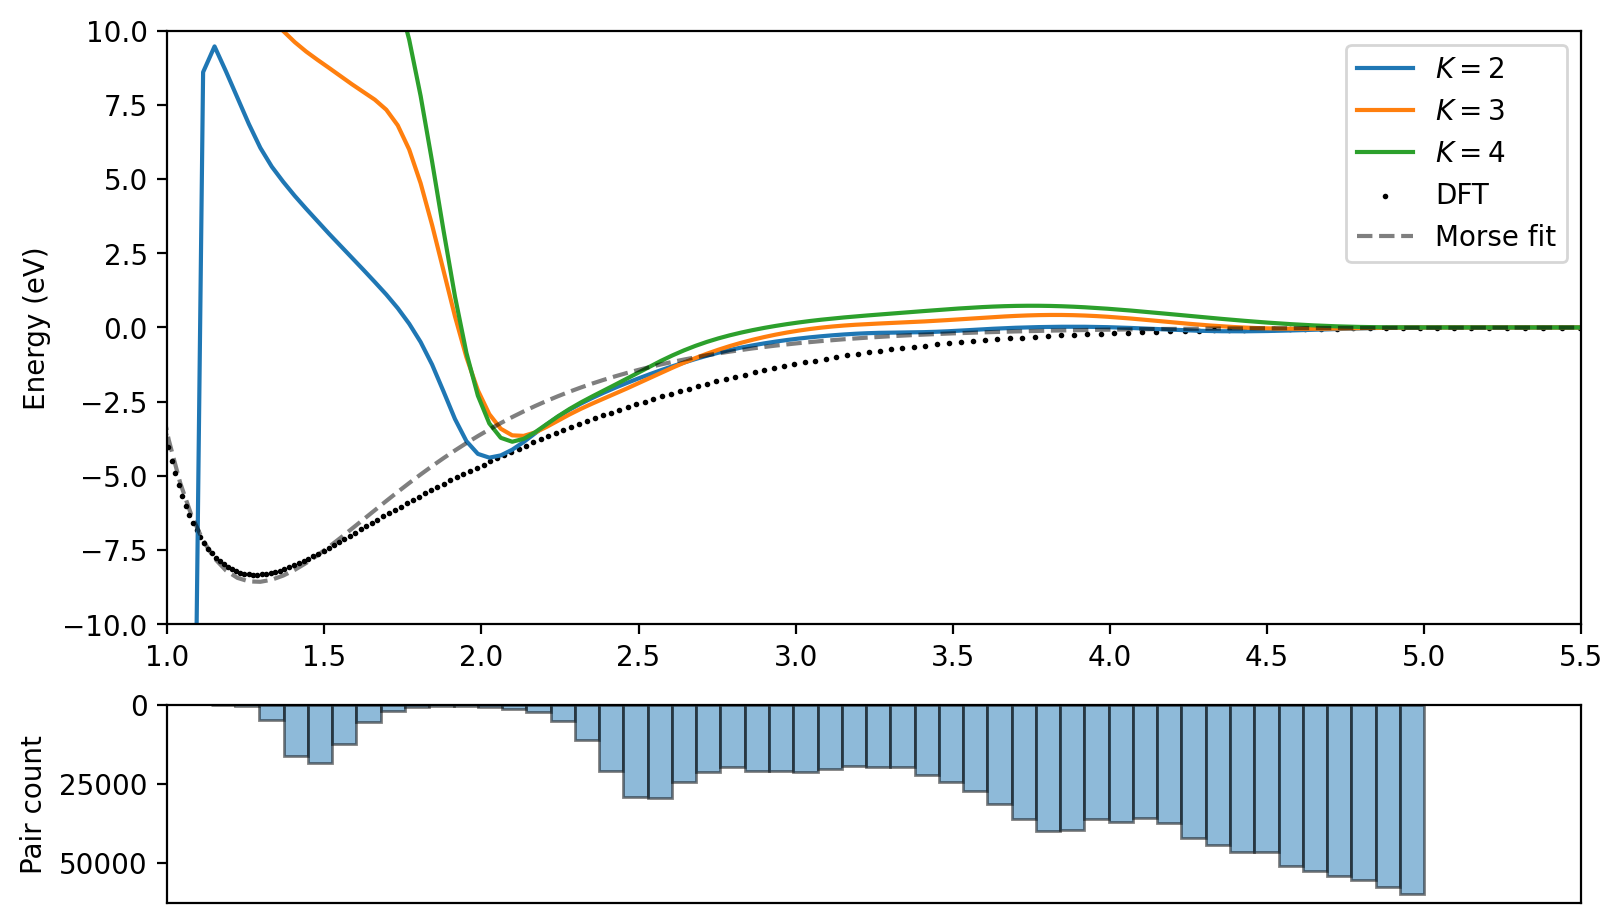

In [46]:
# Done with pacemaker #
def morse_potential(r, a=8.57696795, b=2.00550983, c=1.28317311, d=-8.57696795):
    return a * (1 - np.exp(-b * (r - c)))**2 + d

os.chdir('/leonardo_work/Sis25_degironc_0/apol/codefiles_Convergence-of-body-orders-in-linear-ace')
r = np.linspace(0.75,8,200)
en_qe = np.loadtxt('datafiles/es01_dimer250.dat').T
en_qe[0] *= 0.529177 # bohr to Angstrom
en_qe[1] -= -18.03977639 * 2 # remove e1b
en_qe[1] *= 13.605703976 # Rydberg to eV

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/datasets/pair_distributions/')
counts,bins = np.loadtxt('Tr1k_n_histogram.dat')

os.chdir('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/pacemaker/Tr1k_n_morse/border/')
pots = ['b_order'+str(i)+'/' for i in range(2,5)]

# g,gax = plt.subplots(1,1,figsize=(8,4.5),dpi=200)

fig = plt.figure(constrained_layout=True, figsize=(8, 4.5),dpi=200)
gs = fig.add_gridspec(2,1,height_ratios=[3,1], hspace=0.05)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0], sharex=ax1)

for i,pot in enumerate(pots):
    ax1.plot(r, en_ase(r, pot, 'output_potential.yaml'), label=r'$K=%i$'%(i+2))
ax1.scatter(*en_qe,s=1,color='k',label='DFT')
ax1.plot(r,morse_potential(r), label='Morse fit', color='k', linestyle='--', alpha=0.5)
ax1.set_ylim(-10,10)
ax1.legend()
ax1.set_xlim(1,5.5)
ax1.set_ylabel('Energy (eV)')
ax2.set_xlabel('Distance (A)')
ax2.get_xaxis().set_visible(False)

ax2.invert_yaxis()
ax2.bar(bins,counts, width=bins[1]-bins[0], align='edge', edgecolor='black', alpha=0.5)
ax2.set_ylabel('Pair count')
# ax2.bar(bins[:-1], counts, width=np.diff(bins[:-1]), align='edge', edgecolor='black', alpha=0.5)
    
fig.savefig('/leonardo_work/Sis25_degironc_0/apol/aceconverge2025/figures/pacemaker_morse_fit.png', bbox_inches='tight')